
Data Understanding

The data we will use to perform this analysis was obtained from Kaggle dataset dataset which was obtained via the Riot API. It includes data from 9,879 high ranking (Diamond I to Master) competitive matches with 19 features per team and one target variable which indicates whether the match resulted in a win for the blue team.

Glossary of Features:

    Ward: An item that players can place on the map to reveal the nearby area. Very useful for map/objectives control.

    Assist: Awards partial gold and experience points when damage is done to contribute to an enemy's death.

    Elite Monsters: Monsters with high hp/damage that give a massive bonus (gold/XP/stats) when killed by a team.

    Dragon: AKA Drake. This powerful neutral monster grants various permanent effects and buffs when when killed by a team.

    Herald: A monster that spawns on the eigth minute. Grants a buff that allows the user to spawn the Herald for your team to help push towers and lanes.

    Tower: A structure that blocks the enemy’s path to the base. They take high damage and fire at opponents within a certain radius.

    Gold: Currency awarded for killing monsters or enemy players as well as for completing objectives.

    Level: Champion level. Start at 1. Max is 18.

    Minions: Non-player characters (NPCs) that spawn from each team’s base.
    
    Jungle Minions: NPC that belong to NO TEAM. They give gold and temporary buffs when killed by players.



In [10]:
from sklearn import metrics
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline




In [11]:
df = pd.read_csv('..\\data\\processed\\lol_clean_data2.csv')
df.describe()
non_std_df = df



df.info()

In [12]:
# Creating new dfs 
target_df = df.loc[:,'blueWins']
no_target_df = df.loc[:, df.columns != 'blueWins']
target_df

0       0
1       0
2       0
3       0
4       0
       ..
9874    1
9875    1
9876    0
9877    0
9878    1
Name: blueWins, Length: 9879, dtype: int64

# Standardizing dataset


In [13]:
# Making a Scaler obj
sc = preprocessing.StandardScaler()
scaled_df = sc.fit_transform(no_target_df)
scaled_df = pd.DataFrame(scaled_df, columns=no_target_df.columns)
df = pd.concat([target_df,scaled_df], axis=1)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,0.316996,-0.379275,0.990429,0.935301,-0.046926,1.071495,-0.753226,-0.481132,-0.210439,-0.992782,-1.465951,-0.399207,1.532493,0.329496,-0.838966,-0.436495,-0.198353,-0.928741,0.367685
1,0,-0.570992,-0.839069,-1.009663,-0.393216,-0.387796,-0.404768,-0.753226,-0.481132,-0.210439,-1.953558,-0.758722,-0.561751,-0.805870,-1.148188,1.191944,2.290977,4.412301,1.033784,0.068504
2,0,-0.404494,-1.298863,-1.009663,0.271042,1.657424,-0.650812,1.327623,-0.481132,-0.210439,-1.404543,-0.455624,-0.399207,0.129475,1.807181,-0.838966,-0.436495,-0.198353,-0.654900,-2.324944
3,0,1.149484,-0.839069,-1.009663,-0.725346,-0.387796,-0.404768,-0.753226,2.078430,-0.210439,-0.718275,0.453671,-0.399207,-0.338198,0.822058,-0.838966,-0.436495,-0.198353,0.805583,-0.430131
4,0,2.925460,0.540312,-1.009663,-0.061087,-0.046926,-0.158724,-0.753226,-0.481132,-0.210439,-0.306513,0.655736,-0.290844,-0.338198,0.083215,1.191944,-0.436495,-0.198353,0.349182,1.564408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,-0.293496,-0.379275,0.990429,0.271042,-0.728666,-0.404768,1.327623,-0.481132,-0.210439,-0.260762,1.868129,1.280419,0.129475,0.083215,-0.838966,-0.436495,-0.198353,0.531742,-1.726582
9875,1,1.759976,-1.298863,-1.009663,-0.061087,-0.728666,0.333364,1.327623,-0.481132,-0.210439,0.745765,-0.253559,-0.561751,8.547582,-0.901908,-0.838966,-0.436495,-0.198353,-0.517980,0.467412
9876,0,0.039499,-0.839069,-1.009663,-0.061087,0.293944,-0.404768,-0.753226,-0.481132,-0.210439,-0.306513,-0.556657,-0.453388,-1.273543,1.068338,1.191944,-0.436495,-0.198353,1.992226,0.866319
9877,0,-0.459994,0.540312,0.990429,-1.389604,-1.069536,-0.896856,1.327623,-0.481132,-0.210439,0.334004,-0.253559,2.364049,0.597148,-1.394469,-0.838966,-0.436495,-0.198353,1.353264,-1.128220


# Split Data

In [14]:
y = df[['blueWins']]
X = df.drop(y, axis=1)




In [15]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(7409, 19) (2470, 19) (7409, 1) (2470, 1)


# Median vs Mean

In [16]:
print(
    f'The median for the training set is: {y_train.mean()}, The median for the trainning set is: {y_train.median()}')


The median for the training set is: blueWins    0.504522
dtype: float64, The median for the trainning set is: blueWins    1.0
dtype: float64


# Data Modeling

In [17]:
def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4,
                   figsize=(10, 5), params=False):

    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)

    # Classification Report / Scores

    print("****CLASSIFICATION REPORT - TRAINING DATA****")

    print(metrics.classification_report(y_train, y_hat_train, digits=digits))

    print("****CLASSIFICATION REPORT - TEST DATA****")

    print(metrics.classification_report(y_test, y_hat_test, digits=digits))

    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

    fig, axes = plt.subplots(ncols=2,
                             figsize=figsize)

    # Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test, normalize='true',
                                  cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC Curve
    metrics.plot_roc_curve(model, X_test, y_test, ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0, 1], [0, 1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')

    plt.tight_layout()
    plt.show()

    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns = ['parameters']
        display(params)



def fit_eval(model, X_train, y_train, X_test, y_test, digits=4,
             figsize=(10, 5), params=False):

    model.fit(X_train, y_train)

    evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits,
                   figsize=figsize, params=params)

    return model


# Logistic Regression Model

C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7184    0.7145    0.7165      3671
           1     0.7211    0.7250    0.7231      3738

    accuracy                         0.7198      7409
   macro avg     0.7198    0.7198    0.7198      7409
weighted avg     0.7198    0.7198    0.7198      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7383    0.7308    0.7346      1278
           1     0.7145    0.7223    0.7184      1192

    accuracy                         0.7267      2470
   macro avg     0.7264    0.7266    0.7265      2470
weighted avg     0.7268    0.7267    0.7268      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


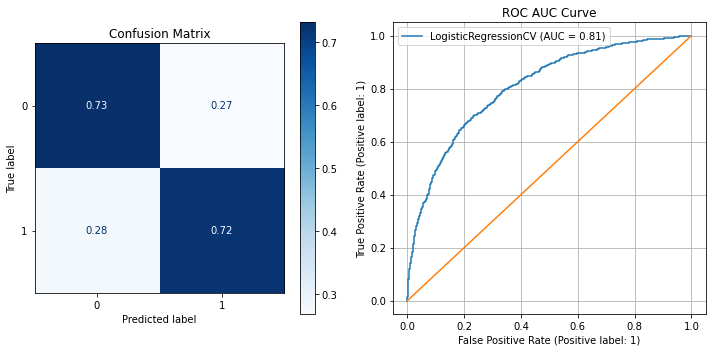

In [18]:
log = fit_eval(LogisticRegressionCV(random_state=123),\
    X_train, y_train,\
        X_test, y_test)



Our out of the box model was good considering we haven't tuned our hyperparameters. We will do that in the furture but now lets discuss what our model returned. We can see that our macro recall score which is calculated by TruePositives / (TruePositives + FalseNegatives) so our logistic regression model accurately predicted about 72.67% or true wins and losses. There is a lot of room to improve since we are inaccurate about 26% of the time. Hopefully tuning our parameters will help. 

# Logistic Regression with GridSearchCV

In our earlier example of the Logistic Regression, we created an instance of our model without passing it any initializers. Instead, we rely on the default values of the various parameters. Lets try and fine tune their values so that our algorithm works best. 

In [19]:
log_grid = LogisticRegression(random_state=123)

# parameter grid
params = {
    'penalty' : ["l1","l2"],
    'C' : np.logspace(-3,3,7),
    'solver': ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
    'class_weight': ["balance"],
    
}

log_grid = GridSearchCV(log_grid, params, scoring='recall_macro', cv=10)
log_grid.fit(X_train, y_train)

C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1358, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 939, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=123),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': ['balance'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='recall_macro')

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7226    0.7159    0.7192      3671
           1     0.7235    0.7301    0.7268      3738

    accuracy                         0.7230      7409
   macro avg     0.7230    0.7230    0.7230      7409
weighted avg     0.7230    0.7230    0.7230      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7324    0.7238    0.7281      1278
           1     0.7075    0.7164    0.7120      1192

    accuracy                         0.7202      2470
   macro avg     0.7200    0.7201    0.7200      2470
weighted avg     0.7204    0.7202    0.7203      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


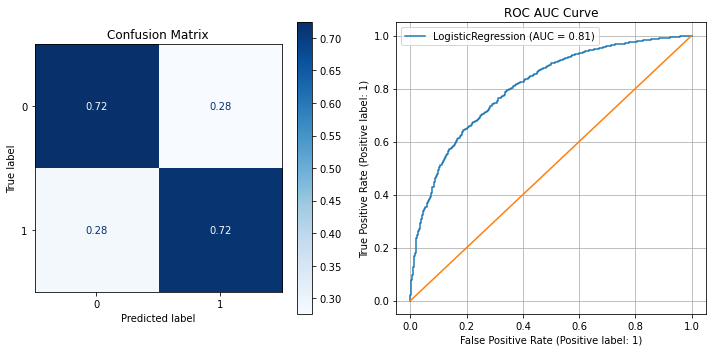

In [20]:
evaluate_model(log_grid.best_estimator_, X_train, y_train,
               X_test, y_test)


After, fine-tunning our hyperparameters we saw a minuscule decrease in our average recall score. I do not want to fall into the overfitting pitfall, let us approach hyperparameter tuning randomly.

# Logistic Regression with RandomSearchCV

In [21]:
log_rand = LogisticRegression()
param_grid = {
     "C": np.arange(0,4,1),
    }

log_rand = RandomizedSearchCV(estimator=log_rand,
                              param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=123, n_jobs=-1)
log_rand.fit(X_train,y_train)



C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 4 candidates, totalling 40 fits


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.71790841 0.71790841 0.7179086 ]
  warnings.warn(
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([0, 1, 2, 3])},
                   random_state=123, verbose=2)

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7184    0.7145    0.7165      3671
           1     0.7211    0.7250    0.7231      3738

    accuracy                         0.7198      7409
   macro avg     0.7198    0.7198    0.7198      7409
weighted avg     0.7198    0.7198    0.7198      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7383    0.7308    0.7346      1278
           1     0.7145    0.7223    0.7184      1192

    accuracy                         0.7267      2470
   macro avg     0.7264    0.7266    0.7265      2470
weighted avg     0.7268    0.7267    0.7268      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


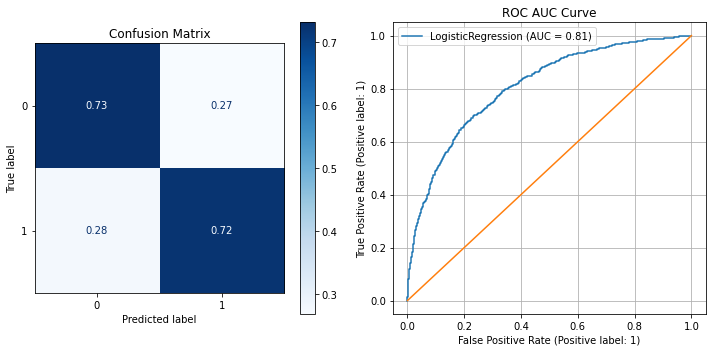

In [22]:
evaluate_model(log_rand.best_estimator_, X_train, y_train,
               X_test, y_test)


We didn't see a significat improvement tuning our parameters using RandomSearchCV vs GridSearchCV. We can see that it was less expensive to run RandomSearchCV in comparasion to GridSearchCV. We'll try a different model to try and more accurate model without overfitting. 

# Random Forest
The model was creating using the original data that was not standardize. 


In [23]:
non_X = non_std_df.loc[:, non_std_df.columns != 'blueWins']
non_y = non_std_df[['blueWins']]


<ipython-input-17-e917609fcacb>:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3671
           1     1.0000    1.0000    1.0000      3738

    accuracy                         1.0000      7409
   macro avg     1.0000    1.0000    1.0000      7409
weighted avg     1.0000    1.0000    1.0000      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7390    0.7246    0.7317      1278
           1     0.7108    0.7257    0.7181      1192

    accuracy                         0.7251      2470
   macro avg     0.7249    0.7251    0.7249      2470
weighted avg     0.7254    0.7251    0.7252      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


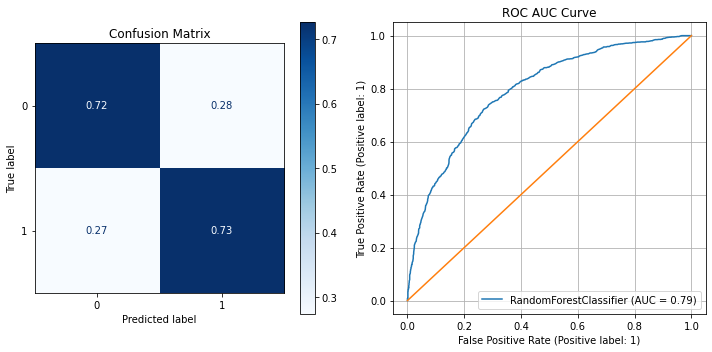

RandomForestClassifier(n_estimators=500, random_state=123)

In [24]:
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(non_X, non_y, test_size=.25, random_state=123)


fit_eval(RandomForestClassifier(random_state=123, n_estimators=500), X_train_non, y_train_non,X_test_non,y_test_non)

Our Random Forest model is scoring perfectly on the training data. This is an evidenct overfitting issue. Lets try to combat the overfitting with some optimal hyperparameter tuning. 

In [25]:

non_X_xgb = non_std_df.loc[:, non_std_df.columns != 'blueWins']
non_y_xgb = non_std_df[['blueWins']].values.reshape(-1,1)

X_train_non_xgb, X_test_non_xgb, y_train_non_xgb,y_test_non_xgb= train_test_split(non_X_xgb, non_y_xgb, random_state=123)

X_test_non_xgb = X_test_non_xgb[X_train_non_xgb.columns]


# XGBoost with Random Forest Model

C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[14:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7416    0.7232    0.7323      3671
           1     0.7347    0.7525    0.7435      3738

    accuracy                         0.7380      7409
   macro avg     0.7381    0.7379    0.7379      7409
weighted avg     0.7381    0.7380    0.7380      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7331    0.6941    0.7130      1278
           1     0.6897    0.7290    0.7088      1192

    accuracy                         0.7109      2470
   macro avg     0.7114    0.7115    0.7109      2470
wei

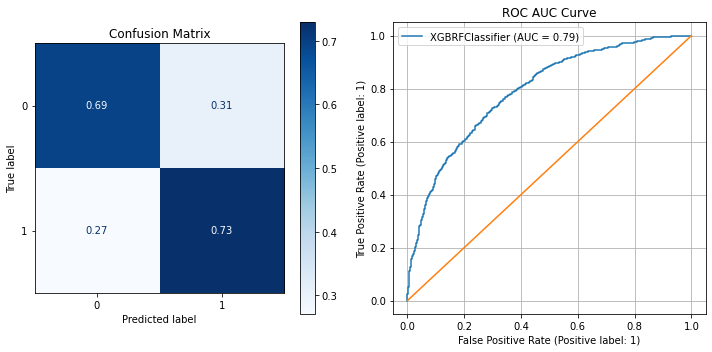

In [26]:
from sklearn.metrics import confusion_matrix
xgb_clf = XGBRFClassifier(random_state=123)
xgb_clf.fit(X_train_non_xgb,y_train_non_xgb)
y_hat_test = xgb_clf.predict(X_test_non_xgb)
y_hat_train = xgb_clf.predict(X_train_non_xgb)

digits=4
print("****CLASSIFICATION REPORT - TRAINING DATA****")

print(metrics.classification_report(y_train, y_hat_train, digits=digits))

print("****CLASSIFICATION REPORT - TEST DATA****")

print(metrics.classification_report(y_test, y_hat_test, digits=digits))

print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

figsize=(10,5)
fig, axes = plt.subplots(ncols=2,
                         figsize=figsize)

# Confusion Matrix
metrics.plot_confusion_matrix(xgb_clf, X_test_non_xgb,
                              y_test_non_xgb, normalize='true',
                              cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

# Plot ROC Curve
metrics.plot_roc_curve(xgb_clf, X_test_non_xgb, y_test_non_xgb, ax=axes[1])

ax = axes[1]
ax.legend()
ax.plot([0, 1], [0, 1], ls='-')
ax.grid()
ax.set_title('ROC AUC Curve')

plt.tight_layout()
plt.show()


Our XGBRF model has been the best model so far. Still dealing with a bit of an overfitting issue but we are heading in the right direction. Lets try to tune our hyperparameters. 

# XGBoost with Hyperparameter Tuning

In [27]:
# Tuned Hyperparaters
xgb_rf = XGBRFClassifier(random_state=123)
params = {'learning_rate': [0.03, 0.05, 0.06],
          'max_depth': [4, 5, 6],
          'min_child_weight': [2, 3, 4],
          'subsample': [0.3, 0.4, 0.5],
          'n_estimators': [100]}
xgb_grid = GridSearchCV(xgb_clf, params, scoring='recall_macro')
xgb_grid.fit(X_train_non_xgb, y_train_non_xgb, eval_metric='rmse')

C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassif

GridSearchCV(estimator=XGBRFClassifier(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bytree=1,
                                       enable_categorical=False, gamma=0,
                                       gpu_id=-1, importance_type=None,
                                       interaction_constraints='',
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=8,
                                       num_parallel_tree=100,
                                       objective='binary:logistic',
                                       predictor='auto', random_state=123,
                                       reg_alpha=0, scale_pos_weight=1,
                                       tree_method='exact',
                      

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7416    0.7232    0.7323      3671
           1     0.7347    0.7525    0.7435      3738

    accuracy                         0.7380      7409
   macro avg     0.7381    0.7379    0.7379      7409
weighted avg     0.7381    0.7380    0.7380      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7331    0.6941    0.7130      1278
           1     0.6897    0.7290    0.7088      1192

    accuracy                         0.7109      2470
   macro avg     0.7114    0.7115    0.7109      2470
weighted avg     0.7121    0.7109    0.7110      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


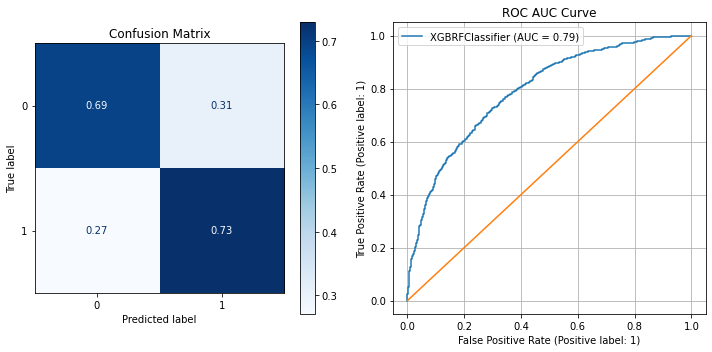

****MODEL PARAMETERS****


,parameters
colsample_bynode,0.8
learning_rate,1.0
reg_lambda,0.00001
subsample,0.8
use_label_encoder,True
objective,binary:logistic
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bytree,1


In [28]:
evaluate_model(xgb_clf, X_train_non_xgb, y_train_non_xgb, X_test_non_xgb, y_test_non_xgb, params=True)

# Coefficient Analysis
Our best performing models without overfitting or under fitting were our basic logistic regression and XGBoost with hyperparameter tuning with accurating predicting 73.24% and 73.48% respectfully. 

Using these two models, we can now extract the feature coefficients and importances in order to identify how much impact each of those elements have on the outcome of the game. Although, our XGBoost model was our best performing model it was also the most costly out of the two. This is why we are running our coefficent analysis on the two best performing models. 


# Logistic Regression Feature Importance

In [29]:
log_coef = pd.Series(log.coef_.flatten(),
                     index=X_train.columns).sort_values(ascending=False)
log_odds = np.exp(log_coef)-1
log_odds



blueKills                       1.000380
blueTotalMinionsKilled          0.293900
blueTotalJungleMinionsKilled    0.246051
blueDragons                     0.182369
blueTowersDestroyed             0.082369
blueAssists                     0.050217
blueFirstBlood                  0.045237
blueHeralds                     0.037125
blueWardsPlaced                 0.009947
blueWardsDestroyed              0.008826
redWardsDestroyed              -0.022483
redWardsPlaced                 -0.039950
redHeralds                     -0.042183
redAssists                     -0.061529
redTowersDestroyed             -0.063402
redDragons                     -0.092997
redTotalJungleMinionsKilled    -0.125276
redTotalMinionsKilled          -0.209829
blueDeaths                     -0.482001
dtype: float64

(-0.4, 0.4)

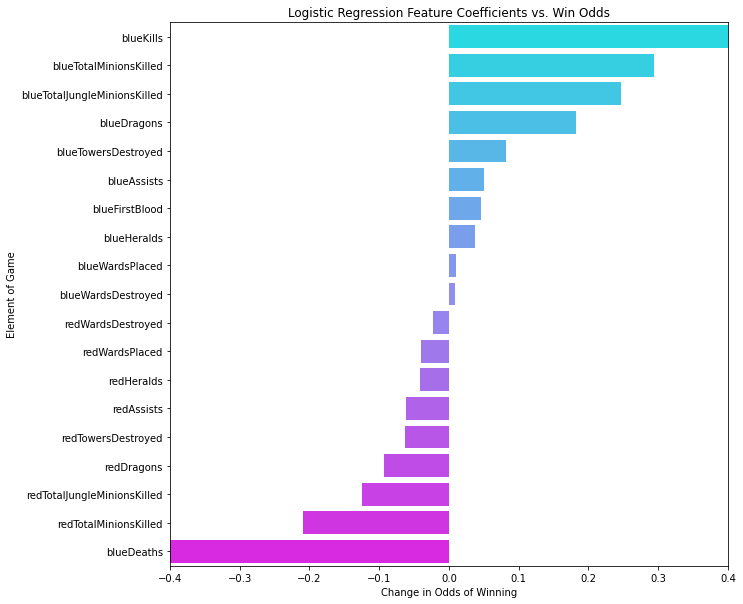

In [30]:
# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x=log_odds.values, y=log_odds.index,
            palette='cool', ax=ax, orient='h')

ax.set_title('Logistic Regression Feature Coefficients vs. Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Element of Game')
ax.set_xlim([-.4, .4])


According to our bar plot using our data from the logistic regression model, we see that Kills and Minions killed within the first 10 minutes of the game have by far the most impact on the outcome of a match. 

# XGBoost Random Forest Feature Importance

Text(0, 0.5, 'Element of Game')

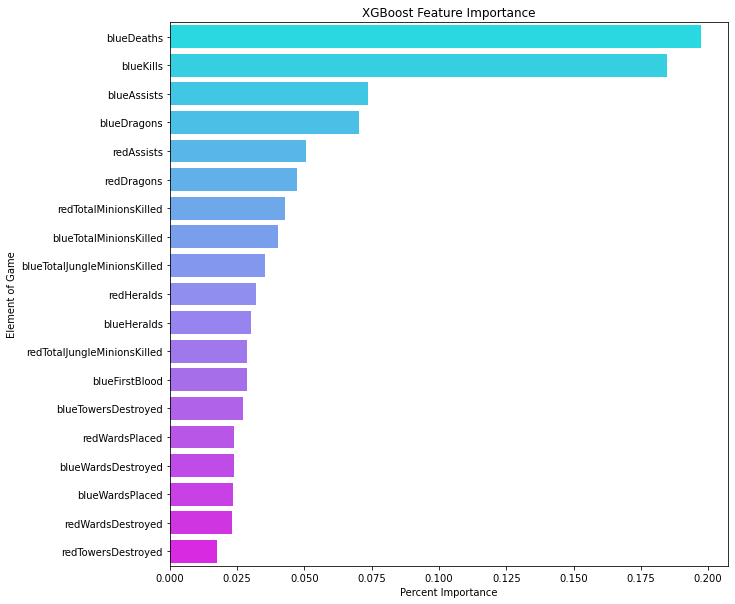

In [31]:
xgb_importance = pd.Series(xgb_grid.best_estimator_.feature_importances_,
                           index=X_train.columns).sort_values(ascending=False)
# Create bar plot of feature importances.
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x=xgb_importance.values, y=xgb_importance.index,
            palette='cool', ax=ax, orient='h')

ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Element of Game')


# Individual Features vs Win Rate

Lets, take a lot at what win rates we get against individual features that were deemed highly important by our coefficient anaylsis. 

# Win or Loss using Minions

In [33]:
df_viz = non_std_df.copy()
df_minions = df_viz.groupby('blueWins').agg('mean')['blueTotalMinionsKilled']
df_minions


blueWins
0    211.793090
1    221.624949
Name: blueTotalMinionsKilled, dtype: float64

(200.0, 225.0)

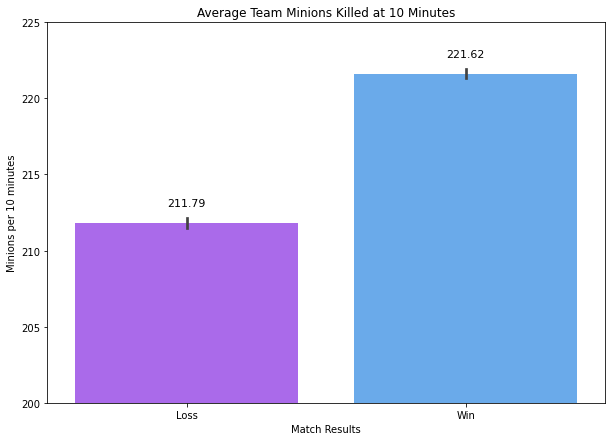

In [34]:
# Create bar plot of mean number of minions killed for losses and wins
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=df_viz, x='blueWins', y='blueTotalMinionsKilled',
            palette='cool_r', ax=ax, ci=68)

ax.set_title('Average Team Minions Killed at 10 Minutes')
ax.set_xlabel('Match Results')
ax.set_ylabel('Minions per 10 minutes')
ax.set_xticklabels(['Loss', 'Win'])

# Method for displaying values at the top of bars found at:
# https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart
x_axis = ax.get_xticklabels()
y_axis = [df_minions.values]

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()), ha='center',
                va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')

ax.set_ylim([200, 225])


We can see that the difference between a loss and a win measuring by minions killed at the 10 min mark is about a 10 minion difference which adds up to approximately 818 gold. We should aim to farm as a team at or above 222 minions to maximize our chance at winning the game.

# Win or Loss using Jungle Minions

In [35]:
# Create series that displays the mean jungle minions killed for matches that
# resulted in losses and wins.
df_jungle = df_viz.groupby('blueWins')\
                  .agg('mean')['blueTotalJungleMinionsKilled']
df_jungle


blueWins
0    49.211154
1    51.813185
Name: blueTotalJungleMinionsKilled, dtype: float64

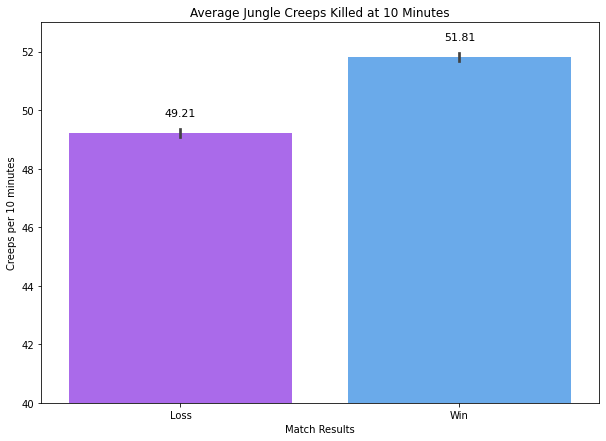

In [36]:
# Create bar plot of mean number of jungle minions killed for losses and wins
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=df_viz, x='blueWins',
            y='blueTotalJungleMinionsKilled', palette='cool_r', ax=ax, ci=68)

ax.set_title('Average Jungle Creeps Killed at 10 Minutes')
ax.set_xlabel('Match Results')
ax.set_ylabel('Creeps per 10 minutes')
ax.set_xticklabels(['Loss', 'Win'])

x_axis = ax.get_xticklabels()
y_axis = [df_jungle.values]

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()), ha='center',
                va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')

ax.set_ylim([40, 53])


# Win or Loss Using Kill Count

In [37]:
# Calculate percent of games won for each number of kills per game

# Calculate total matches for each kill count
df_kills = non_std_df.copy()
df_kills_total = df_kills.groupby('blueKills').count()
df_kills_total = df_kills_total[['blueWins']]
# Calculate number of won matches for each kill count
df_kills_won = df_kills.groupby('blueKills').sum()
df_kills_percent_won = df_kills_won['blueWins'] / df_kills_total['blueWins']
# Display percent of wins per kill count
df_kills_percent_won


blueKills
0     0.142857
1     0.191693
2     0.244663
3     0.278081
4     0.407251
5     0.422427
6     0.510590
7     0.556239
8     0.599788
9     0.687587
10    0.707780
11    0.747059
12    0.803922
13    0.897959
14    0.843750
15    0.842105
16    0.966667
17    1.000000
18    1.000000
19    1.000000
22    1.000000
Name: blueWins, dtype: float64

Text(0, 0.5, 'Win Rate')

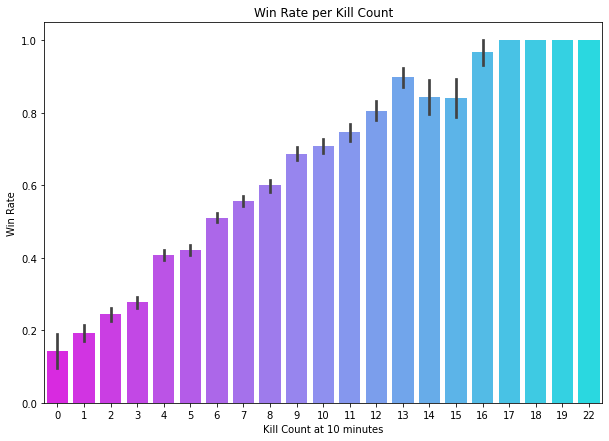

In [38]:
# Create bar plot of kills vs win rates.
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=df_viz, x='blueKills', y='blueWins',
            palette='cool_r', ax=ax, ci=68)

ax.set_title('Win Rate per Kill Count')
ax.set_xlabel('Kill Count at 10 minutes')
ax.set_ylabel('Win Rate')


It is easy to identify that there is a very high correlation between winning and the number of kills a team has. Since we are looking to increase our win rate by at least 1% we recommend that shooting for 7 kills puts us over that 51%. 

# Win or Loss using Dragon Kills

In [39]:
# Calculate percent of games won for dragons killed or not

# Calculate total matches for dragons killed or not
df_drag = non_std_df.copy()
df_drag_total = df_drag.groupby('blueDragons').count()
df_drag_total = df_drag_total[['blueWins']]
# Calculate number of won matches for dragons killed or not
df_drag_won = df_drag.groupby('blueDragons').sum()
df_drag_percent_won = df_drag_won['blueWins'] / df_drag_total['blueWins']
# Display percent of wins for dragons killed or not
df_drag_percent_won


blueDragons
0    0.418531
1    0.640940
Name: blueWins, dtype: float64

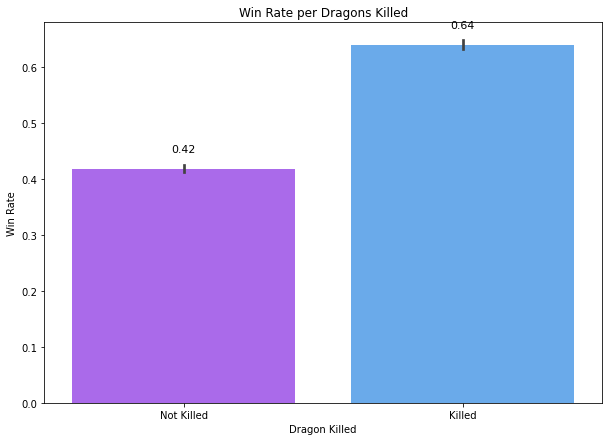

In [40]:
# Create bar plot of Dragons vs win rate
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=df_viz, x='blueDragons', y='blueWins',
            palette='cool_r', ax=ax, ci=68)

ax.set_title('Win Rate per Dragons Killed')
ax.set_xlabel('Dragon Killed')
ax.set_ylabel('Win Rate')
ax.set_xticklabels(['Not Killed', 'Killed'])

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()), ha='center',
                va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')


# Conclusions & Recommendations

Based on the above findings, we can see that gold, experience, and dragons kills the highest impact on the outcome of a LoL game.

My primary recommendation would be to focus heavily on gaining gold by having all the laners (top, mid, and adc) focus on last hitting minions since there are a total of 107 minions that spawn per lane within the first 10mins of the match. 

My second recommendation is to focus on staying in lane and try to absorb as much XP as possible while avoiding getting killed. 

Lastly, killings dragons will impact the possibility of winning. We can do this by warding the river and sweeping for wards before the dragon spawns. 

Some considerations for further analysis would include:

- Analyzing data collected at the end of each match to identify what elements of the game led to a quicker vs slower victory.

- Collect data on a specific team to identify what areas need to be targeted.

